# Cold Gravitational Collapse N-body simulation
#### Intro to Computational Physics Final Project Fall 2022 
#### Bhairavi Chandersekhar

In [160]:
import numpy as np
from numpy          import empty, zeros, pi, sin, cos, arccos, arctan, floor, sqrt
from numpy.random   import default_rng
from scipy.constants    import G

from math import ceil

import matplotlib as mpl
import matplotlib.pyplot as plt

from findiff import Gradient

In [ ]:
# FIXME BUG HACK TODO XXX NOTE

In [161]:
plt.style.use("seaborn-v0_8-dark-palette")
mpl.rcParams['axes.titlesize'] = 15.0
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.labelsize'] = 12.0
mpl.rcParams['axes.titlepad'] = 40 
mpl.rcParams['font.family'] = ['serif']

In [220]:
# Physical constants 
L = 1 #length of domain (m)
Rs = L/4
Np = 8**3 #FIXME number of particles, should be 32**3 for final
mp = 0.1 #mass per particle (kg)
Ms = Np*mp
tdyn = sqrt((pi**2)*(Rs**3)/(4*G*Ms))


# Simulation constants
Nc = 32 # FIXME SHOULD BE 128 for final
a = 1/Nc  # spacing between grid squares
Nbins = 100 # number of bins when making the mass accumulation function

# Particle positions, velocities, and accelerations
pos = empty((Np, 3)) #stores the r, phi, theta components of the positions
vel = empty((Np, 3)) #stores the r, phi, theta components of the velocities
accel = empty((Np, 3)) #stores the r, phi, theta components of the accelerations

# Original mass profile
r = np.linspace(0.01, Rs, 100)
M = Ms * (r/Rs)**3
aExpected = G * M / (r**2)

#### (1/10) Initial Conditions

In [222]:
# helper function for visualizing positions of particles
def posVis(pos): 
    # Plotting x-y and y-z positions
    fig1, ax1 = plt.subplots() #x-y plot
    fig2, ax2 = plt.subplots() #y-z plot

    ax1.scatter(pos[:,0], pos[:,1], s=40, alpha=0.6, edgecolors="k")
    ax1.set_xlim(0.25, 0.75)
    ax1.set_ylim(0.25, 0.75)
    ax1.set_title("Initial Particle Positions (x-y plot)")
    ax1.set_xlabel("x (m)")
    ax1.set_ylabel("y (m)")

    ax2.scatter(pos[:,1], pos[:,2], s=40, alpha=0.6, edgecolors="k")
    ax2.set_xlim(0.25, 0.75)
    ax2.set_ylim(0.25, 0.75)
    ax2.set_title("Initial Particle Positions (y-z plot)")
    ax2.set_xlabel("y (m)")
    ax2.set_ylabel("z (m)")

# Generates the enclosed mass and acceleration plots since they both require
# Calculating distance
def plots2(pos, acc): 
    # 1. Generate enclosed mass profile 
    # Calculate the radius for each particle
    dist = np.empty((Np))
    for i in range(Np): 
        p = pos[i]
        x, y, z = p[0], p[1], p[2]
        dx, dy, dz = abs(0.5 - x), abs(0.5-y), abs(0.5 - z)
        value = sqrt((dx**2)+(dy**2)+(dz**2))
        dist[i] = value
    
    # Bin the particle distances 
    bins, binEdges = np.histogram(dist, Nbins, (0, 0.5))

    # Calculate the enclosed mass 
    eMass = zeros((Nbins)) 
    eMass[0] = bins[0] * mp
    for i in range(1, Nbins): 
        eMass[i] = eMass[i - 1] + bins[i] * mp

    # Plot the enclosed mass profile
    fig_emp, ax_emp = plt.subplots()
    ax_emp.plot(binEdges[1:101], eMass, label="current")

    # Compare to the original enclosed mass profile
    ax_emp.plot(r, M, color="orange", label="initial")

    # Set title and labels
    ax_emp.set_title("Enclosed Mass Profile")
    ax_emp.set_xlabel("Distance from Center (m)")
    ax_emp.set_ylabel("Enclosed Mass (kg)")

    # 2. Generate the particle acceleration profile
    accMag = empty((Np))
    for i in range(Np): 
        ax, ay, az = acc[i, 0], acc[i, 1], acc[i, 2]
        accMag[i] = sqrt(ax**2+ay**2+az**2)
    
    fig_acc, ax_acc = plt.subplots()

    # Plot the particle acceleration profile
    ax_acc.plot(dist, accMag, label = "current")

    # Compare to the expected acceleration profile
    ax_acc.plot(r, aExpected, color = "orange", label = "expected")

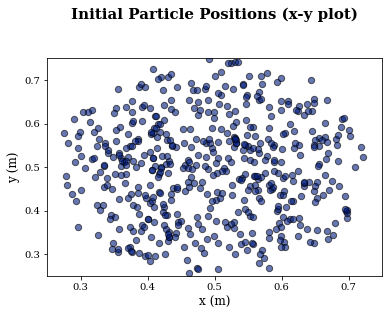

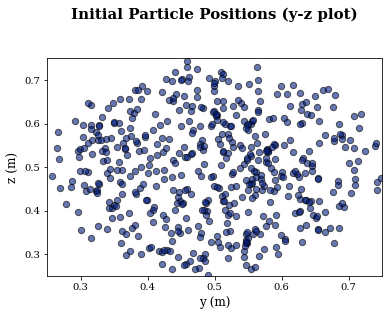

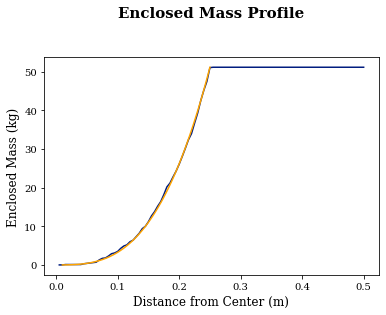

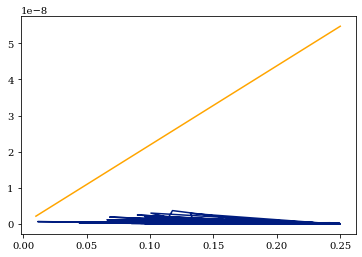

In [223]:
# Generating initial particle positions
rng = default_rng(1)

def random_particle():
    x = rng.random()
    r = np.cbrt(3*x) * 0.17337 # coefficient is the 0.25/cube root of 3

    x = rng.random()
    phi = x*2*pi

    x = rng.random()
    theta = arccos(1-2*x)

    x = r*cos(phi)*sin(theta) + 0.5
    y = r*sin(phi)*sin(theta) + 0.5
    z = r*cos(theta) + 0.5
    return np.array([x, y, z])
    
for p in range(Np):
    pos[p] = random_particle()

posVis(pos)
plots2(pos, acc)


#### (2/10) Density Field

In [167]:
# CIC helper functions
# input: coords is a numpy array [x, y, z] with coordinates of a particle
# output: indices is a numpy array [xIndex, yIndex, zIndex]
# indices contains the indices of the grid array containing
# the center of the particle
def returnIndices(coords):
    indices = empty(6, int)

    # First determine center coordinates
    center = empty(3, int)
    for i in range(3):
        center[i] = floor(coords[i]/a)

    # Then determine the rest of the coordinates
    for i in range(3):
        if coords[i] - 0.5*a < center[i]*a:
            indices[2*i] = center[i] - 1
            indices[2*i+1] = center[i]
        else: 
            indices[2*i] = center[i]
            indices[2*i+1] = center[i] + 1
    
    return indices

# input: coords is a numpy array [x, y, z] with coordinates of a particle
# output: overlaps contains [delx1, delx2, dely1, dely2, delz1, delz2]
# delx1 is overlap in xIndex, delx2 is overlap in xIndex + 1, etc. 
def returnOverlaps(coords, indices):
    overlaps = empty(6)

    for i in range(3):
        i1, i2 = indices[2*i], indices[2*i+1]
        if i1 == -1: 
            overlaps[i*2] = 0
        else: 
            overlaps[i*2] = abs(i2*a - (coords[i]-0.5*a))
        if i2 == Nc: 
            overlaps[i*2+1] = 0
        else: 
            overlaps[i*2+1] = a - overlaps[i*2]
    return overlaps

#input: pos is the numpy array with coordinates of all particles
#output: density array is global variable
def CIC1(pos): 
    density = np.zeros((Nc, Nc, Nc))
    for p in pos: 
        ind = returnIndices(p)
        o = returnOverlaps(p, ind)
        i1, j1, k1 = ind[0], ind[2], ind[4]
        i2, j2, k2 = ind[1], ind[3], ind[5]
        delx1, delx2, dely1, dely2, delz1, delz2, = o[0], o[1], o[2], o[3], o[4], o[5]
        
        delm1 = mp*delx1*dely1*delz1/(a**6)
        density[i1, j1, k1] += delm1

        delm2 = mp*delx1*dely1*delz2/(a**6)
        density[i1, j1, k2] += delm2

        delm3 = mp*delx1*dely2*delz1/(a**6)
        density[i1, j2, k1] += delm3

        delm4 = mp*delx1*dely2*delz2/(a**6)
        density[i1, j2, k2] += delm4

        delm5 = mp*delx2*dely1*delz1/(a**6)
        density[i2, j1, k1] += delm5

        delm6 = mp*delx2*dely1*delz2/(a**6)
        density[i2, j1, k2] += delm6

        delm7 = mp*delx2*dely2*delz1/(a**6)
        density[i2, j2, k1] += delm7

        delm8 = mp*delx2*dely2*delz2/(a**6)
        density[i2, j2, k2] += delm8

    return density

#input: positions is Np x 3 array with the coordinates of all the particles
# forcefield is a 3 x Nc x Nc x Nc ndarray with the Fx Fy and Fz components
#of the force field at each grid cell 
#output: accel is a Np x 3 array with the ax ay and az components of the 
#particle acceleration for each particle
def CIC2(pos, forcefield):
    accel = zeros((Np, 3))
    for p in range(Np): 
        coords = pos[p]
        #calculate the indices
        ind = returnIndices(coords)
        #calculate the overlap
        o = returnOverlaps(coords, ind)
        #unwrap variables
        i1, j1, k1 = ind[0], ind[2], ind[4]
        i2, j2, k2 = ind[1], ind[3], ind[5]
        delx1, delx2, dely1, dely2, delz1, delz2, = o[0], o[1], o[2], o[3], o[4], o[5]
        
        delm1 = forcefield[:, i1, j1, k1]*delx1*dely1*delz1/(a**3)
        accel[p] += delm1

        delm2 = forcefield[:, i1, j1, k2]*delx1*dely1*delz2/(a**3)
        accel[p] += delm2

        delm3 = forcefield[:, i1, j2, k1]*delx1*dely2*delz1/(a**3)
        accel[p] += delm3

        delm4 = forcefield[:, i1, j2, k2]*delx1*dely2*delz2/(a**3)
        accel[p] += delm4

        delm5 = forcefield[:, i2, j1, k1]*delx2*dely1*delz1/(a**3)
        accel[p] += delm5

        delm6 = forcefield[:, i2, j1, k2]*delx2*dely1*delz2/(a**3)
        accel[p] += delm6

        delm7 = forcefield[:, i2, j2, k1]*delx2*dely2*delz1/(a**3)
        accel[p] += delm7

        delm8 = forcefield[:, i2, j2, k2]*delx2*dely2*delz2/(a**3)
        accel[p] += delm8
    return accel
acc = CIC2(pos, onePart_forces)
#print(acc[250])


In [168]:
# Actually executing the CIC code for all of the particles
density = CIC1(pos)

In [169]:
# DENSITY CHECK: Checking that total mass is recovered
sum = 0
for i in range(Nc): 
    for j in range(Nc): 
        for k in density[i, j]:
            sum += k

totalMass = sum / (Nc**3) # divide by total # of cells
print("total mass: ", round(totalMass, 1))
print("original mass: ", mp*Np)

total mass:  51.2
original mass:  51.2


In [170]:
# CIC check: single particle FIXME this was for debugging purposes
Nc = 32
a = 1/Nc

x = 0.6
y = 0.51
indices = returnIndices([x, y, 0.54])
print(indices)
print(returnOverlaps([x, y, 0.54], indices))


[18 19 15 16 16 17]
[0.009375 0.021875 0.005625 0.025625 0.006875 0.024375]


#### (3/10) Potential Solver

In [171]:
def PoissonSolver(density): 
    # 1. Forward FFT of density array
    rhok = np.fft.rfftn(density)
    phik = empty((Nc, Nc, Nc//2 + 1), complex)
    # 2. 
    for i in range(Nc): 
        for j in range(Nc): 
            for k in range(Nc//2 + 1): 
                denom = sin(pi*i/Nc)**2 + sin(pi*j/Nc)**2 + sin(pi*k/Nc)**2
                if denom == 0: 
                    phik[i, j, k] = 0
                else: 
                    phik[i, j, k] = -4*pi*G*rhok[i, j, k]/(4*denom)
    phik *= (a**2)
    phi = np.fft.irfftn(phik, density.shape)
    return phi

potential = PoissonSolver(density)

#### (4/10) Force solver (not done)

In [173]:
# Finite differencing the potential field to get the force 

# input: potential is a Nc x Nc x Nc nparray containing the potential at each grid cell
# output: a 3 x Nc x Nc x Nc nparray containing force in the x, y and z directions in each grid cell 
def forceSolver(potential): 
    grad = Gradient(h=[a, a, a])
    F = -1 * grad(potential)
    return F

forces = forceSolver(potential)

#### (5/10) One-particle force test

In [174]:
onePart = np.array([[0.6, 0.51, 0.54]])
#print(returnIndices(np.squeeze(onePart)))

#going from densities to a force field
singleDensity = CIC1(onePart)
pot = PoissonSolver(singleDensity)
onePart_forces = forceSolver(pot)
print (onePart_forces.shape)
print(onePart_forces[:, 15, 15, 15])

(3, 32, 32, 32)
[3.42288703e-10 7.70417514e-11 1.65408510e-10]


In [175]:
# Plotting the single particle test
x, y, z = onePart[0, 0], onePart[0, 1], onePart[0, 2]
Fmag = empty((Nc, Nc, Nc))
Fx_field, Fy_field, Fz_field = onePart_forces[0], onePart_forces[1], onePart_forces[2]

Fmag = abs(sqrt(Fx_field**2 + Fy_field**2, Fz_field**2))
#Calculate distance at each point
distance = empty((Nc, Nc, Nc))

for i in range(Nc): 
    for j in range(Nc): 
        for k in range(Nc): 
            #calculate distance from particle
            xF, yF, zF = i*a + 0.5*a, j*a + 0.5*a, k*a + 0.5*a
            dx, dy, dz = abs(x-xF), abs(y - yF), abs(z - zF)
            value = sqrt(dx**2+dy**2+dz**2)
            distance[i, j, k] = value


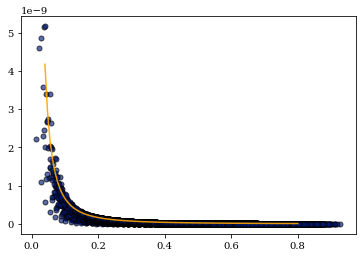

In [176]:
# Plotting force as a function of distance
fig_fd, ax_fd = plt.subplots()
dFlat, fFlat = distance.flatten(), Fmag.flatten()
ax_fd.scatter(dFlat,fFlat, s=25, alpha=0.65, edgecolors="k")
#ax_fd.set_xlim(0.1, 0.2)
#ax_fd.set_ylim(0, 0.1)

#something to compare to 
r = np.linspace(0.04, 0.8, 100)
y = (G * mp) / (r**2)
ax_fd.plot(r, y, color="orange", alpha = 0.9)


In [177]:
def gravitySolver(positions): 
    dens = CIC1(pos)
    pot = PoissonSolver(dens)
    f = forceSolver(pot)
    acc = CIC2(pos, f)

#### (7/9) Results

#### (8/9) Discussion
